<a href="https://colab.research.google.com/github/SiddTayi/ML-Projects/blob/main/LSTM_Temp_Pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

In [2]:
# File location and path
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
csv_path

'/root/.keras/datasets/jena_climate_2009_2016.csv'

In [4]:
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


Datetime: %d.%m.%y \
10 minute intervals

In [5]:
df = df[5::6]
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [6]:
df.shape

(70091, 15)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70091 entries, 5 to 420545
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date Time        70091 non-null  object 
 1   p (mbar)         70091 non-null  float64
 2   T (degC)         70091 non-null  float64
 3   Tpot (K)         70091 non-null  float64
 4   Tdew (degC)      70091 non-null  float64
 5   rh (%)           70091 non-null  float64
 6   VPmax (mbar)     70091 non-null  float64
 7   VPact (mbar)     70091 non-null  float64
 8   VPdef (mbar)     70091 non-null  float64
 9   sh (g/kg)        70091 non-null  float64
 10  H2OC (mmol/mol)  70091 non-null  float64
 11  rho (g/m**3)     70091 non-null  float64
 12  wv (m/s)         70091 non-null  float64
 13  max. wv (m/s)    70091 non-null  float64
 14  wd (deg)         70091 non-null  float64
dtypes: float64(14), object(1)
memory usage: 8.0+ MB


In [8]:
df.index = pd.to_datetime(df['Date Time'], format = "%d.%m.%Y %H:%M:%S")

<Axes: xlabel='Date Time'>

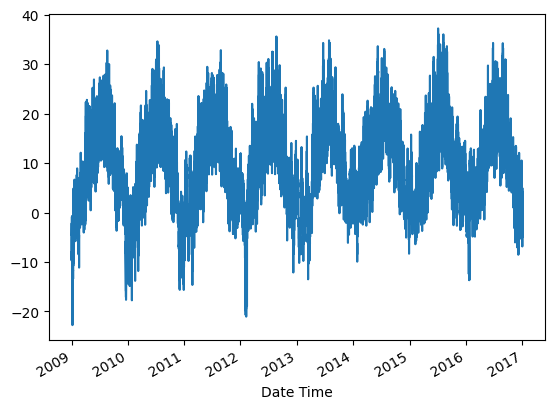

In [9]:
# Get temp
temp = df['T (degC)']
temp.plot()

In [10]:
temp

,T (degC)
Date Time,
2009-01-01 01:00:00,-8.05
2009-01-01 02:00:00,-8.88
2009-01-01 03:00:00,-8.81
2009-01-01 04:00:00,-9.05
2009-01-01 05:00:00,-9.63
...,...
2016-12-31 19:10:00,-0.98
2016-12-31 20:10:00,-1.40
2016-12-31 21:10:00,-2.75


In [11]:
# Take the first 5 hours and predict the 6th hour. Slide the window to the next value to repeat the same process.
# Input hours: X: [[1, 2, 3, 4, 5]] ==> Y: [6]
## Input hours: X2: [[2, 3, 4, 5, 6]] ==> Y: [7]
### Input hours: X3: [[3, 4, 5, 6, 7]] ==> Y: [8]

def df_to_XY(df, window_size = 5):
    df_numpy = df.to_numpy()
    X = [] # [[1, 2, 3, 4, 5]]
    y = [] # [6]
    for i in range(len(df_numpy) - window_size):
        #
        row = [[a] for a in df_numpy[i: i+window_size]]
        X.append(row)
        label = df_numpy[i+window_size]
        y.append(label)

    return np.array(X), np.array(y)


In [12]:
window_size = 5
X, y = df_to_XY(temp, window_size)
X.shape, y.shape

((70086, 5, 1), (70086,))

In [13]:
# Split them into train, test, and validation set

# First 60000 rows
x_train, y_train = X[:60000], y[:60000]

# Val
x_val, y_val = X[60000:65000], y[60000:65000]

# Test
x_test, y_test = X[65000:], y[65000:]

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((60000, 5, 1), (60000,), (5000, 5, 1), (5000,), (5086, 5, 1), (5086,))

In [14]:
# Compile model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [15]:
model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
# model1.add(Dense(8, 'relu'))
model1.add(Dense(16, 'relu'))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,081 (70.63 KB)

 Trainable params: 18,081 (70.63 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Only save the best model - The one with the lowest validation loss.
cp = ModelCheckpoint('model1/best_model.keras', save_best_only = True, verbose = 1)
model1.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.001), metrics = [RootMeanSquaredError()])

In [17]:
model1.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 10, callbacks = [cp])

Epoch 1/10
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.2403 - root_mean_squared_error: 3.9488
Epoch 1: val_loss improved from inf to 0.51166, saving model to model1/best_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 20.2002 - root_mean_squared_error: 3.9443 - val_loss: 0.5117 - val_root_mean_squared_error: 0.7153
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6959 - root_mean_squared_error: 0.8342
Epoch 2: val_loss improved from 0.51166 to 0.50050, saving model to model1/best_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.6959 - root_mean_squared_error: 0.8342 - val_loss: 0.5005 - val_root_mean_squared_error: 0.7075
Epoch 3/10
1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6737 - root_mean_squared_error: 0.8208
Epoch 3: val_loss did not improve from 0.50050
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.6738 - root_mean_squared_error: 0.8208 - val_loss: 0.5590 - val_root_mean_squared_error: 0.7477
Epoch 4/10
1

In [18]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/best_model.keras')

In [19]:
train_predictions = model1.predict(x_train).flatten()
train_results = pd.DataFrame(data = {"Train Predictions": train_predictions, "Actuals": y_train})
train_results

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


,Train Predictions,Actuals
0,-10.151307,-9.67
1,-9.964355,-9.17
2,-8.990294,-8.10
3,-7.436102,-7.66
4,-7.344446,-7.04
...,...,...
59995,6.217279,6.07
59996,7.122823,9.88
59997,12.111571,13.53
59998,15.575509,15.43


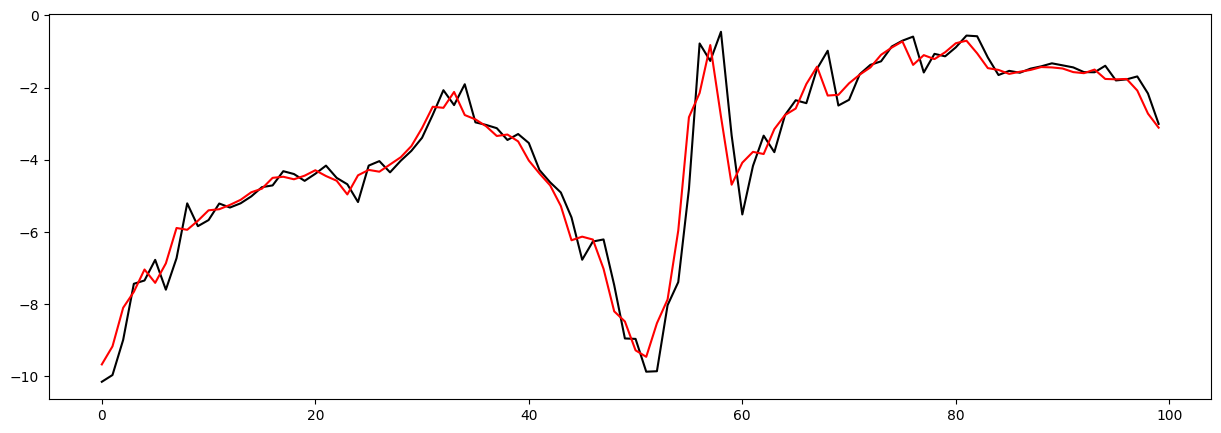

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 5))
plt.plot(train_results['Train Predictions'][:100], color = "black")
plt.plot(train_results['Actuals'][:100], color = "red")

In [21]:
# On Validation dataset
val_predictions = model1.predict(x_val).flatten()
val_results = pd.DataFrame(data = {"Train Predictions": val_predictions, "Actuals": y_val})
val_results

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,Train Predictions,Actuals
0,15.833631,14.02
1,13.436225,13.67
2,13.295470,12.27
3,11.590011,11.19
4,10.568154,10.85
...,...,...
4995,17.486732,18.27
4996,17.760202,17.85
4997,17.245403,16.65
4998,16.016159,15.85


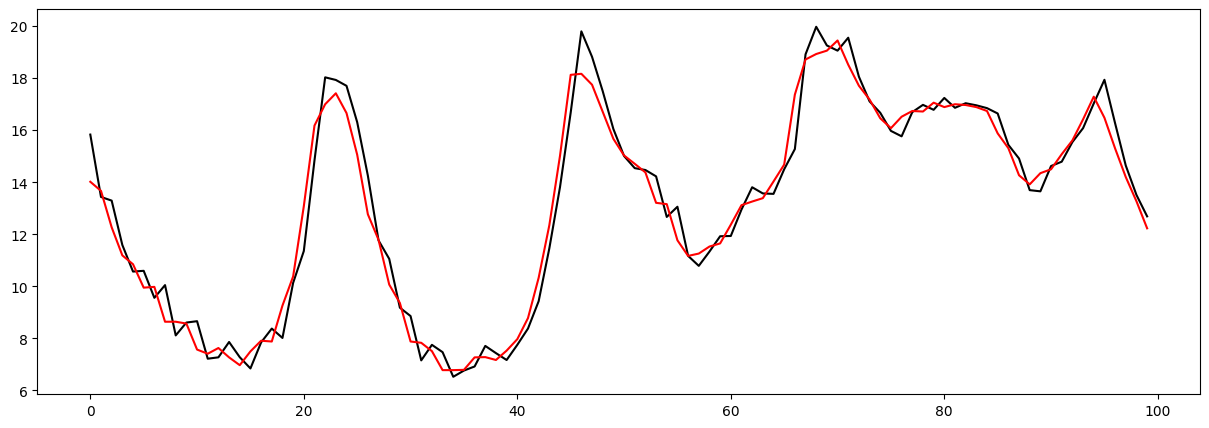

In [22]:
plt.figure(figsize = (15, 5))
plt.plot(val_results['Train Predictions'][:100], color = "black")
plt.plot(val_results['Actuals'][:100], color = "red")

## MODEL 2: CNN

CNNs are generally used to train 2D data but they can also be used on 1D datasets and are much smaller in size when compared to LSTM and other RNNs.

In [23]:
from sklearn.metrics import mean_squared_error as mse
def plot_predictions(model, x, y, start = 0, end = 100):
    predictions = model.predict(x).flatten()
    df = pd.DataFrame(data = {"Predictions": predictions, "Actuals": y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    return df, mse(y, predictions)

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


(      Predictions  Actuals
 0       14.568429    13.99
 1       13.387794    13.46
 2       13.089799    12.93
 3       12.644937    12.43
 4       12.203181    12.17
 ...           ...      ...
 5081    -1.087924    -0.98
 5082    -1.603635    -1.40
 5083    -1.677637    -2.75
 5084    -3.157755    -2.89
 5085    -3.102021    -3.93
 
 [5086 rows x 2 columns],
 0.5974289076257479)

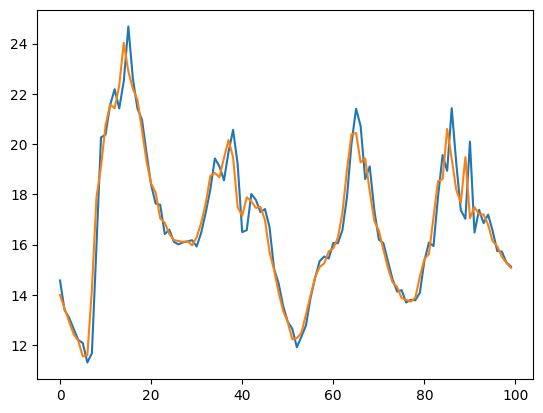

In [24]:
plot_predictions(model1, x_test, y_test)

In [25]:
model2 = Sequential()
model2.add(InputLayer((5,1)))
model2.add(Conv1D(64, kernel_size = 2))
model2.add(Flatten())
# model2.add(Dense(32, 'relu'))
model2.add(Dense(16, 'relu'))
model2.add(Dense(1, 'relu'))

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 4, 64)               │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │           4,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,321 (16.88 KB)

 Trainable params: 4,321 (16.88 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Only save the best model - The one with the lowest validation loss.
cp2 = ModelCheckpoint('model2/best_model.keras', save_best_only = True, verbose = 1)
model2.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.001), metrics = [RootMeanSquaredError()])

In [27]:
# model2.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 10, callbacks = [cp])
model2.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 10, callbacks = [cp2])

Epoch 1/10
1853/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2272 - root_mean_squared_error: 2.4685
Epoch 1: val_loss improved from inf to 1.91373, saving model to model2/best_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 6.2141 - root_mean_squared_error: 2.4660 - val_loss: 1.9137 - val_root_mean_squared_error: 1.3834
Epoch 2/10
1848/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9772 - root_mean_squared_error: 2.2306
Epoch 2: val_loss improved from 1.91373 to 1.90246, saving model to model2/best_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 4.9756 - root_mean_squared_error: 2.2303 - val_loss: 1.9025 - val_root_mean_squared_error: 1.3793
Epoch 3/10
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8960 - root_mean_squared_error: 2.2122
Epoch 3: val_loss did not improve from 1.90246
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4.8960 - root_mean_squared_error: 2.2122 - val_loss: 1.9413 - val_root_mean_squared_error: 1.3933
Epoch 4/10
1849/1

In [28]:
from tensorflow.keras.models import load_model
model2 = load_model('model2/best_model.keras')

In [29]:
train_predictions = model2.predict(x_train).flatten()
train_results = pd.DataFrame(data = {"Train Predictions": train_predictions, "Actuals": y_train})
train_results

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


,Train Predictions,Actuals
0,0.000000,-9.67
1,0.000000,-9.17
2,0.000000,-8.10
3,0.000000,-7.66
4,0.000000,-7.04
...,...,...
59995,6.337393,6.07
59996,7.158119,9.88
59997,12.299181,13.53
59998,15.848201,15.43


159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


(      Predictions  Actuals
 0       14.568429    13.99
 1       13.387794    13.46
 2       13.089799    12.93
 3       12.644937    12.43
 4       12.203181    12.17
 ...           ...      ...
 5081    -1.087924    -0.98
 5082    -1.603635    -1.40
 5083    -1.677637    -2.75
 5084    -3.157755    -2.89
 5085    -3.102021    -3.93
 
 [5086 rows x 2 columns],
 0.5974289076257479)

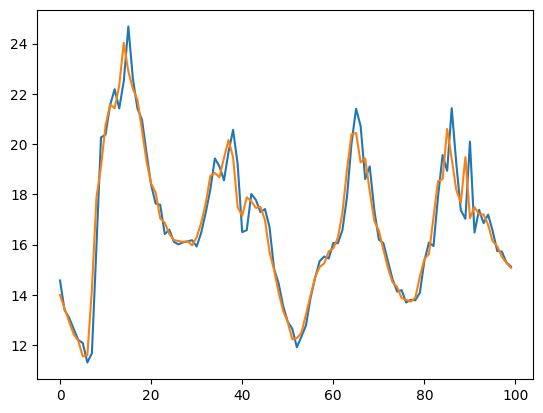

In [30]:
# Plot model 2
plot_predictions(model1, x_test, y_test)

## MODEL 3: GRU: Gated Recurrent Unit

In [31]:
model3 = Sequential()
model3.add(InputLayer((5, 1)))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 64)                  │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,393 (52.32 KB)

 Trainable params: 13,393 (52.32 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
cp3 = ModelCheckpoint('model3/best_model.keras', save_best_only = True)
model3.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.001), metrics = [RootMeanSquaredError()])

In [33]:
model3.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 10, callbacks = [cp3])

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 17.4838 - root_mean_squared_error: 3.6527 - val_loss: 0.5021 - val_root_mean_squared_error: 0.7086
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.6659 - root_mean_squared_error: 0.8160 - val_loss: 0.4932 - val_root_mean_squared_error: 0.7023
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.6519 - root_mean_squared_error: 0.8073 - val_loss: 0.4924 - val_root_mean_squared_error: 0.7017
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.6871 - root_mean_squared_error: 0.8287 - val_loss: 0.6630 - val_root_mean_squared_error: 0.8142
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.6535 - root_mean_squared_error: 0.8083 - val_loss: 0.4994 - val_root_mean_squared_error: 0.7067
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.6587 - root_mean_squared_error: 0.8115 - val_loss: 0.4920 - val_root_mean_squared_error: 0.7014
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━

In [34]:
train_predictions = model3.predict(x_train).flatten()
train_results = pd.DataFrame(data = {"Train Predictions": train_predictions, "Actuals": y_train})
train_results

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


,Train Predictions,Actuals
0,-9.895357,-9.67
1,-9.663602,-9.17
2,-8.713199,-8.10
3,-7.255498,-7.66
4,-7.220963,-7.04
...,...,...
59995,6.201745,6.07
59996,7.265414,9.88
59997,12.026069,13.53
59998,15.370969,15.43


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


(      Predictions  Actuals
 0       14.062787    13.99
 1       12.938125    13.46
 2       12.690507    12.93
 3       12.259039    12.43
 4       11.854864    12.17
 ...           ...      ...
 5081    -1.065956    -0.98
 5082    -1.654778    -1.40
 5083    -1.760499    -2.75
 5084    -3.352086    -2.89
 5085    -3.168520    -3.93
 
 [5086 rows x 2 columns],
 0.8017076266462392)

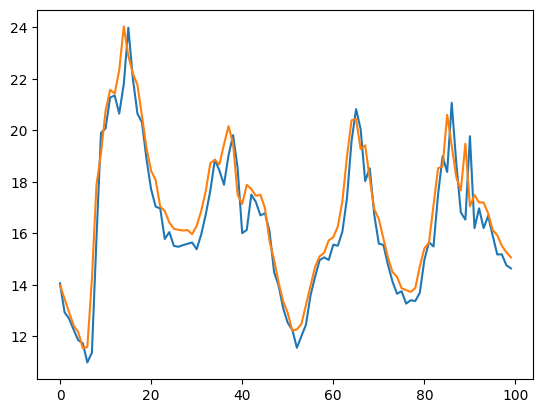

In [35]:
plot_predictions(model3, x_test, y_test)

In [36]:
test_predictions = model3.predict(x_test).flatten()
test_results = pd.DataFrame(data = {"Train Predictions": test_predictions, "Actuals": y_test})
test_results

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Train Predictions,Actuals
0,14.062787,13.99
1,12.938125,13.46
2,12.690507,12.93
3,12.259039,12.43
4,11.854864,12.17
...,...,...
5081,-1.065956,-0.98
5082,-1.654778,-1.40
5083,-1.760499,-2.75
5084,-3.352086,-2.89


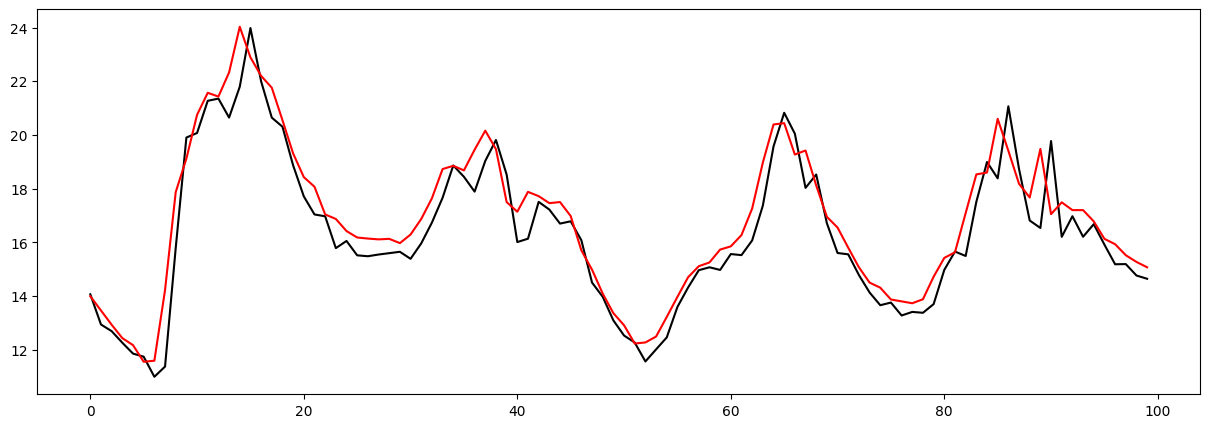

In [37]:
plt.figure(figsize = (15, 5))
plt.plot(test_results['Train Predictions'][:100], color = "black")
plt.plot(test_results['Actuals'][:100], color = "red")

### ADD OTHER FEATURES

In [38]:
temp_df = pd.DataFrame({"Temperature": temp})
temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)
temp_df

,Temperature,Seconds
Date Time,,
2009-01-01 01:00:00,-8.05,1.230772e+09
2009-01-01 02:00:00,-8.88,1.230775e+09
2009-01-01 03:00:00,-8.81,1.230779e+09
2009-01-01 04:00:00,-9.05,1.230782e+09
2009-01-01 05:00:00,-9.63,1.230786e+09
...,...,...
2016-12-31 19:10:00,-0.98,1.483211e+09
2016-12-31 20:10:00,-1.40,1.483215e+09
2016-12-31 21:10:00,-2.75,1.483219e+09


In [39]:
day = 60*60*24
year = 365.2425 * day # no. seconds in 1 year
temp_df['Day Sin'] = np.sin(temp_df['Seconds'] * (2* np.pi / day))
temp_df['Day Cos'] = np.cos(temp_df['Seconds'] * (2* np.pi / day))
temp_df['Year Sin'] = np.sin(temp_df['Seconds'] * (2* np.pi / year))
temp_df['Year Cos'] = np.cos(temp_df['Seconds'] * (2* np.pi / year))


The formula converts timestamps into cyclical features to capture daily patterns. Here's why:

day = 606024 converts days to seconds (86400 seconds/day)
2π/day creates the frequency for one complete cycle per day
Multiplying large timestamp values by this small frequency normalizes them to [0, 2π]
sin() then converts these values to [-1, 1], creating a smooth cyclical pattern



In [40]:
temp_df.head()

,Temperature,Seconds,Day Sin,Day Cos,Year Sin,Year Cos
Date Time,,,,,,
2009-01-01 01:00:00,-8.05,1.230772e+09,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,-8.88,1.230775e+09,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,-8.81,1.230779e+09,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,-9.05,1.230782e+09,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,-9.63,1.230786e+09,0.965926,0.258819,0.012916,0.999917


In [41]:
# Seconds Col: Redundant - Remove
temp_df = temp_df.drop("Seconds", axis = 1)
temp_df.head()

,Temperature,Day Sin,Day Cos,Year Sin,Year Cos
Date Time,,,,,
2009-01-01 01:00:00,-8.05,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,-8.88,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,-8.81,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,-9.05,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,-9.63,0.965926,0.258819,0.012916,0.999917


In [42]:
# Sliding window approach: Using previous 5 hours to predict the next hour
# Input X: [[t1,ds1], [t2,ds2], [t3,ds3], [t4,ds4], [t5,ds5]] => Output Y: [t6]
# Input X: [[t2,ds2], [t3,ds3], [t4,ds4], [t5,ds5], [t6,ds6]] => Output Y: [t7]
# Input X: [[t3,ds3], [t4,ds4], [t5,ds5], [t6,ds6], [t7,ds7]] => Output Y: [t8]

def df_to_XY2(df, window_size = 6):
    df_numpy = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_numpy) - window_size):
        row = [a for a in df_numpy[i: i+window_size]]
        X.append(row)
        label = df_numpy[i+window_size][0]
        y.append(label)

    return np.array(X), np.array(y)


In [43]:
x2, y2 = df_to_XY2(temp_df)
x2.shape, y2.shape

((70085, 6, 5), (70085,))

In [44]:
x2_train, y2_train = x2[:60000], y2[:60000]
x2_val, y2_val = x2[60000:65000], y2[60000:65000]
x2_test, y2_test = x2[65000:], y2[65000:]
x2_train.shape, y2_train.shape, x2_test.shape, y2_test.shape, x2_val.shape, y2_val.shape

((60000, 6, 5), (60000,), (5085, 6, 5), (5085,), (5000, 6, 5), (5000,))

In [45]:
# Preprocessing the above tensors
## Standardize to make all the variables to the same scale.

temp_train_mean = np.mean(x2_train[:, :, 0])
temp_train_std = np.std(x2_train[:, :, 0])

def preprocess(x):
    x[:, :, 0] = (x[:, :, 0] - temp_train_mean) / temp_train_std
    return x


In [ ]:
preprocess(x2_train)
preprocess(x2_val)
preprocess(x2_test)

## LSTM

In [47]:
model4 = Sequential()
model4.add(InputLayer((6, 5)))
model4.add(LSTM(64))
model4.add(Dense(32), 'relu')
model4.add(Dense(1), 'linear')

model4.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 64)                  │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,033 (78.25 KB)

 Trainable params: 20,033 (78.25 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
cp4 = ModelCheckpoint('model4/bestmodel.keras', save_best_only = True)
model4.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.001), metrics = [RootMeanSquaredError()])

In [49]:
model4.fit(x2_train, y2_train, validation_data = (x2_val, y2_val), epochs = 10, callbacks = [cp4])

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 15.8147 - root_mean_squared_error: 3.4943 - val_loss: 0.4846 - val_root_mean_squared_error: 0.6961
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.5829 - root_mean_squared_error: 0.7634 - val_loss: 0.4148 - val_root_mean_squared_error: 0.6440
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.5393 - root_mean_squared_error: 0.7343 - val_loss: 0.4772 - val_root_mean_squared_error: 0.6908
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.5561 - root_mean_squared_error: 0.7454 - val_loss: 0.4325 - val_root_mean_squared_error: 0.6577
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.5314 - root_mean_squared_error: 0.7289 - val_loss: 0.4325 - val_root_mean_squared_error: 0.6576
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.5424 - root_mean_squared_error: 0.7362 - val_loss: 0.5148 - val_root_mean_squared_error: 0.7175
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


(      Predictions  Actuals
 0       13.200729    13.46
 1       12.786498    12.93
 2       12.327728    12.43
 3       11.967814    12.17
 4       12.048795    11.55
 ...           ...      ...
 5080    -1.207362    -0.98
 5081    -1.465816    -1.40
 5082    -1.696297    -2.75
 5083    -3.273404    -2.89
 5084    -3.233484    -3.93
 
 [5085 rows x 2 columns],
 0.4795882933878432)

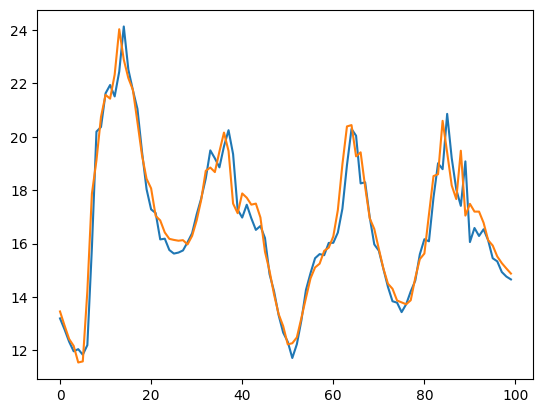

In [50]:
plot_predictions(model4, x2_test, y2_test)

### ADD PRESSURE AS A PREDICTIVE VAR
So predict both temp and pressure

In [51]:
# Use pressure as a predictive variable: So essentially predicting both pressure and temp.
p_temp_df = pd.concat([df['p (mbar)'], temp_df], axis = 1)
p_temp_df.head()

,p (mbar),Temperature,Day Sin,Day Cos,Year Sin,Year Cos
Date Time,,,,,,
2009-01-01 01:00:00,996.50,-8.05,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,996.62,-8.88,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,996.84,-8.81,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,996.99,-9.05,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,997.46,-9.63,0.965926,0.258819,0.012916,0.999917


In [52]:
def df_to_XY3(df, window_size = 7):
    df_numpy = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_numpy) - window_size):
        row = [a for a in df_numpy[i: i+window_size]]
        X.append(row)
        label = [df_numpy[i+window_size][0], df_numpy[i+window_size][1]]
        y.append(label)

    return np.array(X), np.array(y)


In [53]:
x3, y3 = df_to_XY3(p_temp_df)
x3.shape, y3.shape

((70084, 7, 6), (70084, 2))

In [54]:
x3_train, y3_train = x3[:60000], y3[:60000]
x3_val, y3_val = x3[60000:65000], y3[60000:65000]
x3_test, y3_test = x3[65000:], y3[65000:]
x3_train.shape, y3_train.shape, x3_test.shape, y3_test.shape, x3_val.shape, y3_val.shape

((60000, 7, 6), (60000, 2), (5084, 7, 6), (5084, 2), (5000, 7, 6), (5000, 2))

In [55]:
# Preprocessing
pre_train_mean = np.mean(x3_train[:, :, 0])
pre_train_std = np.std(x3_train[:, :, 0])

temp_train_mean = np.mean(x3_train[:, :, 1])
temp_train_std = np.std(x3_train[:, :, 1])


def preprocess1(x):
    x[:, :, 0] = (x[:, :, 0] - pre_train_mean) / pre_train_std
    x[:, :, 1] = (x[:, :, 1] - temp_train_mean) / temp_train_std
    return x


def preprocess_output(y):
    y[:, 0] = (y[:, 0] - pre_train_mean) / pre_train_std
    y[:, 1] = (y[:, 1] - temp_train_mean) / temp_train_std
    return y



In [ ]:
preprocess1(x3_train)
preprocess1(x3_test)
preprocess1(x3_val)


In [57]:
preprocess_output(y3_train)
preprocess_output(y3_val)
preprocess_output(y3_test)

array([[-0.7934386 ,  0.41245076],
       [-0.76312281,  0.35368268],
       [-0.72189335,  0.32312327],
       ...,
       [ 1.48145784, -1.43051636],
       [ 1.41597574, -1.44697142],
       [ 1.35049365, -1.56920903]])

#### LSTM with 2 targets

In [58]:
model5 = Sequential()
model5.add(InputLayer((7, 6)))
model5.add(LSTM(64))
model5.add(Dense(32), 'relu')
model5.add(Dense(2), 'linear')

model5.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 64)                  │          18,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,322 (79.38 KB)

 Trainable params: 20,322 (79.38 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
cp5 = ModelCheckpoint('model6/bestmodel.keras', save_best_only = True)
model5.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.001), metrics = [RootMeanSquaredError()])

In [60]:
model5.fit(x3_train, y3_train, validation_data = (x3_val, y3_val), epochs = 10, callbacks = [cp5])

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.0322 - root_mean_squared_error: 0.1651 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0674
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0060 - root_mean_squared_error: 0.0775 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0629
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0055 - root_mean_squared_error: 0.0740 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0594
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0048 - root_mean_squared_error: 0.0694 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0617
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0047 - root_mean_squared_error: 0.0686 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0599
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0044 - root_mean_squared_error: 0.0664 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0680
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━

In [61]:
def plot_predictions2(model, X, y, start=0, end=100):
  predictions = model.predict(X)
  p_preds, temp_preds = predictions[:, 0], predictions[:, 1]
  p_actuals, temp_actuals = y[:, 0], y[:, 1]
  df = pd.DataFrame(data={'Temperature Predictions': temp_preds,
                          'Temperature Actuals':temp_actuals,
                          'Pressure Predictions': p_preds,
                          'Pressure Actuals': p_actuals
                          })
  plt.plot(df['Temperature Predictions'][start:end])
  plt.plot(df['Temperature Actuals'][start:end])
  plt.plot(df['Pressure Predictions'][start:end])
  plt.plot(df['Pressure Actuals'][start:end])
  return df[start:end]

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


,Temperature Predictions,Temperature Actuals,Pressure Predictions,Pressure Actuals
0,0.411499,0.412451,-0.789373,-0.793439
1,0.361704,0.353683,-0.785749,-0.763123
2,0.317841,0.323123,-0.745782,-0.721893
3,0.324281,0.250251,-0.688456,-0.652773
4,0.284767,0.254952,-0.599226,-0.652773
...,...,...,...,...
95,0.701462,0.716869,-0.418864,-0.416310
96,0.656767,0.687485,-0.418353,-0.399333
97,0.636471,0.663978,-0.395845,-0.399333
98,0.636829,0.641646,-0.392016,-0.400546


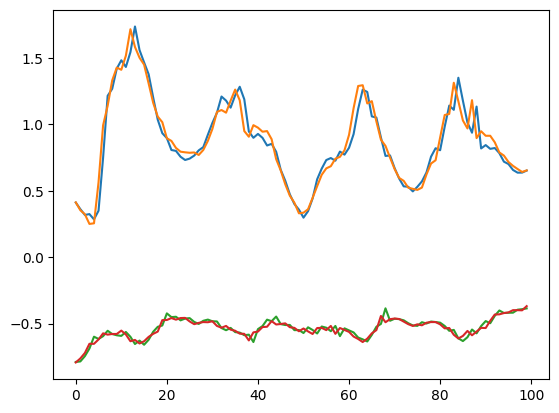

In [62]:
plot_predictions2(model5, x3_test, y3_test)

### POSTPROCESSING

Converting all the predicted values which are scaled to normal values that represent temperature using inverse scaling

In [66]:
def postprocess_temp(arr):
    arr = (arr*temp_train_std) + temp_train_mean
    return arr

def postprocess_pressure(arr):
    arr = (arr*pre_train_std) + pre_train_mean
    return arr

In [76]:
def plot_predictions2(model, X, y, start=0, end=100):
   predictions = model.predict(X)
   p_preds, temp_preds = postprocess_pressure(predictions[:, 0]), postprocess_temp(predictions[:, 1])
   p_actuals, temp_actuals = postprocess_pressure(y[:, 0]), postprocess_temp(y[:, 1])
   df = pd.DataFrame(data={'Temperature Predictions': temp_preds,
                          'Temperature Actuals':temp_actuals,
                          'Pressure Predictions': p_preds,
                          'Pressure Actuals': p_actuals
                          })

   plt.figure(figsize=(12, 8))

   plt.subplot(2,1,1)
   plt.plot(df['Temperature Predictions'][start:end], label='Predicted')
   plt.plot(df['Temperature Actuals'][start:end], label='Actual')
   plt.title('Temperature')
   plt.legend()

   plt.subplot(2,1,2)
   plt.plot(df['Pressure Predictions'][start:end], label='Predicted')
   plt.plot(df['Pressure Actuals'][start:end], label='Actual')
   plt.title('Pressure')
   plt.legend()

   plt.tight_layout()
   return df[start:end].head()

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Temperature Predictions,Temperature Actuals,Pressure Predictions,Pressure Actuals
0,12.921899,12.93,982.463562,982.43
1,12.498245,12.43,982.493469,982.68
2,12.125062,12.17,982.823059,983.02
3,12.179847,11.55,983.295776,983.59
4,11.843664,11.59,984.031616,983.59


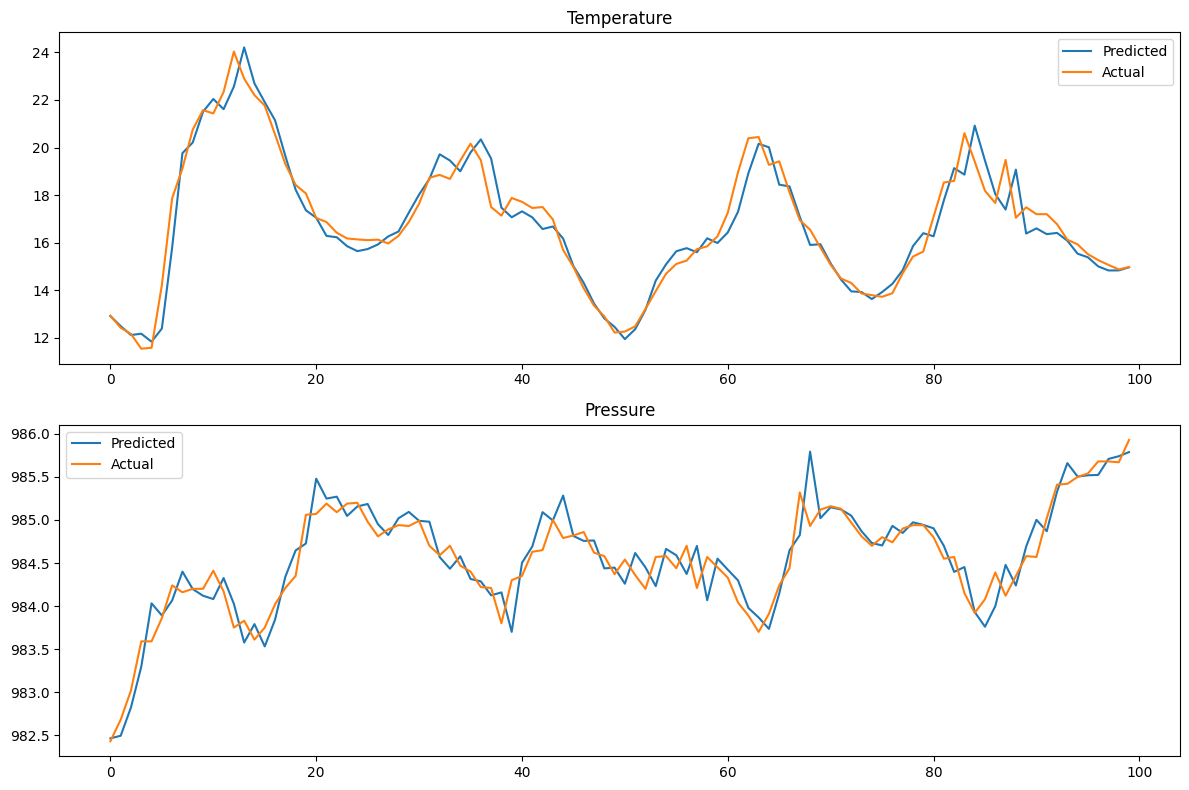

In [77]:
post_processed_df = plot_predictions2(model5, x3_test, y3_test)
post_processed_df

### CONV1D

In [103]:
model7 = Sequential()
model7.add(InputLayer((7, 6)))
model7.add(Conv1D(64, kernel_size = 2, activation = 'relu'))
model7.add(Flatten())
# model2.add(Dense(32, 'relu'))
model7.add(Dense(16, 'relu'))
model7.add(Dense(2, 'linear'))
model7.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 6, 64)               │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 16)                  │           6,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 2)                   │              34 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,026 (27.45 KB)

 Trainable params: 7,026 (27.45 KB)

 Non-trainable params: 0 (0.00 B)

In [104]:
cp7 = ModelCheckpoint('model7/bestmodel.keras', save_best_only = True)
model7.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.001), metrics = [RootMeanSquaredError()])

In [105]:
model7.fit(x3_train, y3_train, validation_data = (x3_val, y3_val), epochs = 10, callbacks = [cp7])

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0609 - root_mean_squared_error: 0.2197 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0798
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0064 - root_mean_squared_error: 0.0799 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0702
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0057 - root_mean_squared_error: 0.0753 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0652
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0052 - root_mean_squared_error: 0.0718 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0727
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0051 - root_mean_squared_error: 0.0715 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0634
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0050 - root_mean_squared_error: 0.0705 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0638
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━

In [106]:
def plot_predictions2(model, X, y, start=0, end=100):
   predictions = model.predict(X)
   p_preds, temp_preds = postprocess_pressure(predictions[:, 0]), postprocess_temp(predictions[:, 1])
   p_actuals, temp_actuals = postprocess_pressure(y[:, 0]), postprocess_temp(y[:, 1])
   df = pd.DataFrame(data={'Temperature Predictions': temp_preds,
                          'Temperature Actuals':temp_actuals,
                          'Pressure Predictions': p_preds,
                          'Pressure Actuals': p_actuals
                          })

   plt.figure(figsize=(12, 8))

   plt.subplot(2,1,1)
   plt.plot(df['Temperature Predictions'][start:end], label='Predicted')
   plt.plot(df['Temperature Actuals'][start:end], label='Actual')
   plt.title('Temperature')
   plt.legend()

   plt.subplot(2,1,2)
   plt.plot(df['Pressure Predictions'][start:end], label='Predicted')
   plt.plot(df['Pressure Actuals'][start:end], label='Actual')
   plt.title('Pressure')
   plt.legend()

   plt.tight_layout()
   return df[start:end].head()

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Temperature Predictions,Temperature Actuals,Pressure Predictions,Pressure Actuals
0,12.934371,12.93,982.755249,982.43
1,12.571909,12.43,982.769165,982.68
2,12.070905,12.17,983.051086,983.02
3,12.091334,11.55,983.533386,983.59
4,11.812189,11.59,984.184631,983.59


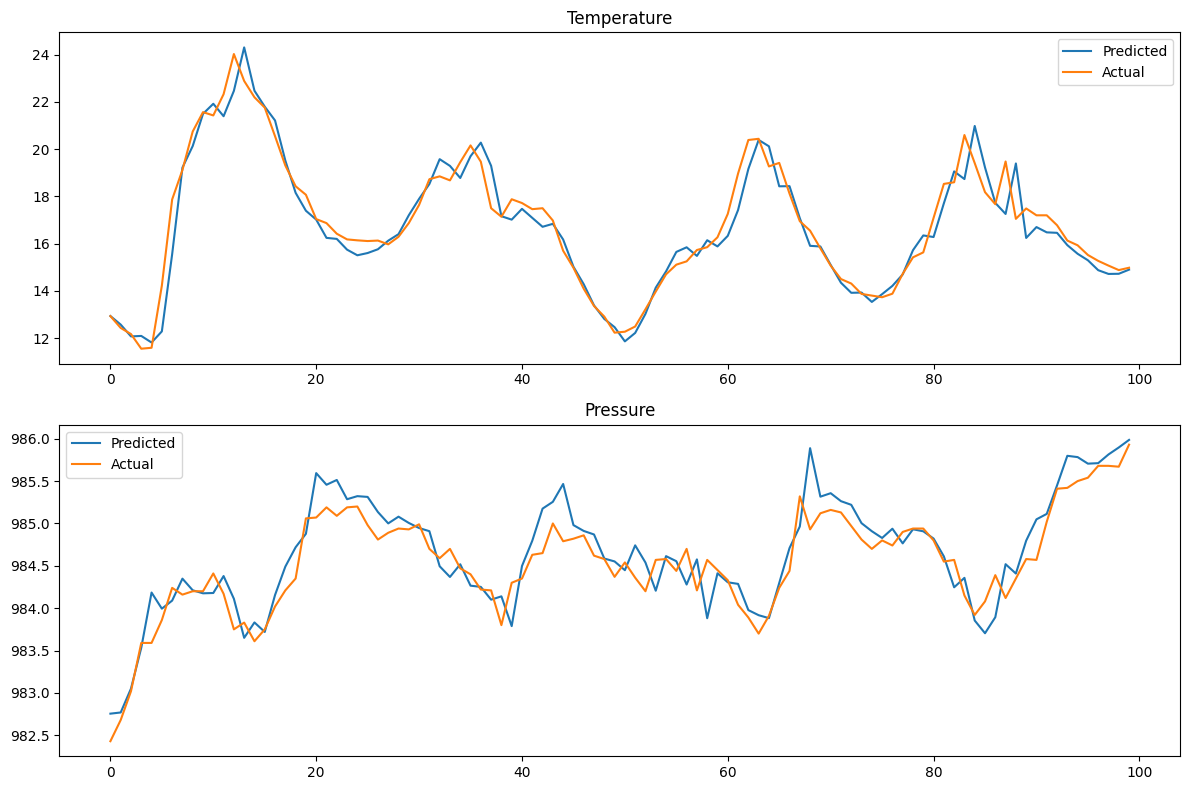

In [107]:
post_processed_df = plot_predictions2(model7, x3_test, y3_test)
post_processed_df